In [1]:
# new model
# 1. 2D Eulerian model (for inert tracer) 
# 2. 1D slab model

# (1) this is very important
# use small enough time step for 1D model, in order to avoid combing slab grid cells, 
# so that there is be less extra fake diffusion induced
# (2)
# change 2D to 1D in later time, to ensure that the plume cross-section is highly skewed,
# make the 1D model model qualified
# (3)
# directly use vertical diffusion in 1D model, which would cause less diffusion in 1D model.


import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

import scipy
from scipy import interpolate
from scipy.sparse import diags
import scipy.sparse as sp

import matplotlib.tri as tri
import matplotlib.pyplot as plt

import pandas as pd

from tqdm import tqdm 

PI = math.pi

In [2]:
# input value

# time step
Dt_2d = 10 # [s]
Dt_1d = 0.5  # [s]

# grid resolution
Dx = 200 # [m]
Dy = 20 # [m]

# grid number
Nx = 5000 # 5000 #243 # 483
Ny = 300  #135 # 271

# define diffusion coefficient
Diff_x = 10.0 # [m2 s-1]
Diff_y = 0.15 # [m2 s-1]

# define a fixed wind field
U_shear = 0.002 # [s-1]

# initial total injected mass
Mass = 1.0 # [kg]
AVO  = 6.022e+23

# running time
time2 = 3600*48 # time for 1d model run

center: 2500 150
U.shape: (300, 5000)


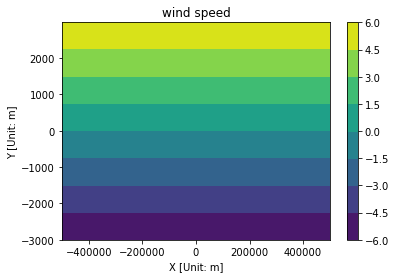

In [3]:
# For high resolution 2D Eulerian model
# for the first 24 hours

Ymax =  Dy*Ny/2
Ymin = -Dy*Ny/2
Xmax =  Dx*Nx/2
Xmin = -Dx*Nx/2


i_init = round(Nx/2)
j_init = round(Ny/2)
print('center:',i_init,j_init)

x = []
for i in range(Nx):
    x.append((i-i_init)*Dx)
    
y = []
for j in range(Ny):
    y.append((j-j_init)*Dy)

X, Y = np.meshgrid(x, y)


V = np.zeros([Ny,Nx]) # [m]
U = np.zeros([Ny,Nx])
print('U.shape:',U.shape)

for j in range(Ny):
    U[j,:] = Y[j,:] * U_shear # [m]
    
plt.contourf(X,Y,U)
plt.colorbar()
plt.xlabel('X [Unit: m]')
plt.ylabel('Y [Unit: m]')
plt.title( 'wind speed' )
plt.show()


1.0


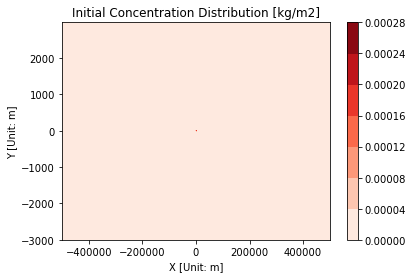

In [4]:
# define initial concentration distribution

Concnt = np.zeros([Ny,Nx])


Concnt[j_init,i_init] = Mass/(Dx*Dy) # [kg m-2]
# Concnt[j_init,i_init] = Concnt[j_init,i_init] / 1.0e+6 / 98.0 * AVO

Original = Concnt[j_init,i_init]*Dx*Dy
print(Original)

contours = plt.contourf(X, Y, Concnt, cmap='Reds')
plt.xlabel('X [Unit: m]')
plt.ylabel('Y [Unit: m]')
plt.title( 'Initial Concentration Distribution [kg/m2]' )
plt.colorbar()


plt.show()

In [5]:
def Adv_Diff2(C, U, Diff_x, Diff_y, Dt, Dx, Dy, Nx, Ny):
    C_new = C*0.0
    C2    = C*0.0

    i = Nx
    j = Ny
    
    alpha = Dt*U[:,1:Nx-1]/Dx
    C2[:,1:Nx-1] = C[:,1:Nx-1] - 0.5*alpha*(C[:,2:Nx]-C[:,0:Nx-2]) \
                          + 0.5*alpha**2*(C[:,2:Nx]-2*C[:,1:Nx-1]+C[:,0:Nx-2])
      
#     for j in range(0,Ny,1):
#         alpha = Dt*U[j,1]/Dx
#         C2[j,1:Nx-1] = C[j,1:Nx-1] - 0.5*alpha*(C[j,2:Nx]-C[j,0:Nx-2]) \
#                             + 0.5*alpha**2*(C[j,2:Nx]-2*C[j,1:Nx-1]+C[j,0:Nx-2])

    C_new[1:Ny-1,1:Nx-1] = C2[1:Ny-1,1:Nx-1] + \
                             Dt*( Diff_x*(C2[1:Ny-1,0:Nx-2]+C2[1:Ny-1,2:Nx]-2*C2[1:Ny-1,1:Nx-1])/(Dx*Dx) \
                                + Diff_y*(C2[0:Ny-2,1:Nx-1]+C2[2:Ny,1:Nx-1]-2*C2[1:Ny-1,1:Nx-1])/(Dy*Dy) )
    
    return C_new

In [6]:
# The function can calculate the scale length (Xscale, Yscale) 
# of the input concentration distribution (Concnt)

def Get_XYscale(Concnt, Dx, Dy, Nx, Ny, frac):
    
    M2d = Concnt*Dx*Dy
    total_mass = np.sum(M2d, axis=(0,1))
    
    Ysum = np.sum(M2d,axis=1) # sum along x axis
    Ysum_sort = sorted(Ysum, reverse=True)
    Ysum_cum = np.cumsum(Ysum_sort)
    numY = abs(Ysum_cum - frac*total_mass).argmin()
    Yscale = numY*Dy
    
    Xsum = np.sum(M2d,axis=0) # sum along x axis
    Xsum_sort = sorted(Xsum, reverse=True)
    Xsum_cum = np.cumsum(Xsum_sort)
    numX = abs(Xsum_cum - frac*total_mass).argmin()
    Xscale = numX*Dx
    
    return Xscale, Yscale

In [7]:
# Test confusion CFL condition

if 2*Diff_y*Dt_2d/(Dy**2)>1:
    print('****************************************')
    print('WARNING: diff Y: CFL condition is not satisfied')
    print('Try to increase Dy or decrease Dt_2d')
    print('****************************************')
    
if 2*Diff_x*Dt_2d/(Dx**2)>1:
    print('****************************************')
    print('WARNING: diff X: CFL condition is not satisfied')
    print('Try to increase Dx or decrease Dt_2d')
    print('****************************************')
    
# Test advective CFL condition
if np.max(U)*Dt_2d/Dx>1:
    print('****************************************')
    print('WARNING: adv X: CFL condition is not satisfied')
    print('Try to increase Dx or decrease Dt_2d')
    print('****************************************')

    contours = plt.contourf(X,Y,Concnt)
#    plt.clabel(contours, inline=True, fontsize=8)
    plt.show()

In [8]:
%%time

# time run
Nt           = int(3600*6/Dt_2d)

# Judge_radian = (90-2)/180*PI # [radians]
scale_ratio  = 25

Theta        = 0.0           # [radians]
Height       = 0.0           #[m]
frac = 0.95

for t in tqdm(range(Nt)):    
    Concnt = Adv_Diff2(Concnt, U, Diff_x, Diff_y, Dt_2d, Dx, Dy, Nx, Ny)
    
    Xscale, Yscale = Get_XYscale(Concnt, Dx, Dy, Nx, Ny, frac)
    Theta = math.atan(Xscale/Yscale)
    
    if (t+1)*Dt_2d>3600*2:
        if Xscale/Yscale>scale_ratio:
            print(t*Dt_2d/3600, Xscale, Yscale)
            break        

#    print(Concnt[j_init,:])
#    print(sum(map(sum, Concnt)))
    # if the long Vs. short radius is larger than 20:1, 
    # then stop 2D model, begin 1D model;
    # check this every one hour
#     Theta = np.arctan( np.tan(Theta) + U_shear*Dt_2d ) # this one can be optimise
#     Height = np.sqrt(Height**2 + 2*Diff_y*Dt_2d)
#     if Theta>Judge_radian: # change to 1D model
#         print(t*Dt_2d/3600)
#         break

 91%|█████████ | 1965/2160 [02:44<00:16, 11.98it/s]

5.458333333333333 7200 280
CPU times: user 1min 57s, sys: 46.5 s, total: 2min 44s
Wall time: 2min 44s


In [9]:
time1 = (t+1)*Dt_2d  # initial time for 1-D grids
time1/3600

5.461111111111111

In [10]:
math.degrees(Theta)

87.77295303258643

0 0


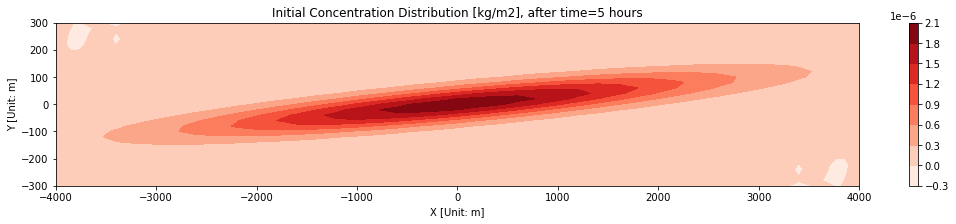

In [11]:
fig, ax = plt.subplots(1, figsize=(18,3))

levs = (1e-45, 1e-40, 1e-35, 1e-30, 1e-25, 1e-20, 1e-15, 1e-10, 1e-5, 1e0)
contours = plt.contourf(X, Y, Concnt, cmap='Reds')
# contours = plt.contourf(X, Y, Concnt, levs, locator=ticker.LogLocator(), cmap='Reds', extend='max')

# plt.ylim(Ymin, Ymax)
# plt.xlim(Xmin, Xmax)

plt.ylim(-3e2, 3e2)
plt.xlim(-4e3, 4e3)

plt.colorbar()
plt.xlabel('X [Unit: m]')
plt.ylabel('Y [Unit: m]')
plt.title( 'Initial Concentration Distribution [kg/m2], after time='+str(int(time1/3600))+' hours' )
print(X[j_init,i_init],Y[j_init,i_init])

plt.show()


In [12]:
#########################################################
#
# 2D to 1D
#
##########################################################

In [13]:
def tilt_C2d(Concnt, x, y, Dx, Dy, Nx, Ny, Theta, Na, Nb, LenA, LenB):
    
    # find the long and short radius given concentration distribution
    # build a 2D nest for integrationn
    Nb_mid = int(Nb/2)

    # interval in long radius
    Adx = LenA*np.sin(Theta)
    Ady = LenA*np.cos(Theta)

    # interval in short radius
    Bdy = LenB*np.sin(Theta)
    Bdx = LenB*np.cos(Theta)

    # define the location in 2D xy mesh used to determine initial concentration
    Y1d = np.zeros((Na,Nb))
    X1d = np.zeros((Na,Nb))

    print('Y1d.shape: ', Y1d.shape)

    # find the location of 1D grid in 2D XY grids
    for i in range(Na):
        X1d[i,Nb_mid] = -Adx*Na/2 + Adx*(i+0.5)   # ???
        Y1d[i,Nb_mid] = -Ady*Na/2 + Ady*(i+0.5)   # ???

    for j in range(Nb_mid+1, Nb, 1):
        X1d[:,j] = X1d[:,j-1] - Bdx
        Y1d[:,j] = Y1d[:,j-1] + Bdy
    
    for j in range(Nb_mid-1, -1, -1):
        X1d[:,j] = X1d[:,j+1] + Bdx
        Y1d[:,j] = Y1d[:,j+1] - Bdy

        
    # set the initial concentration for 1D
    C1d = np.zeros((Na,Nb))

    # Find the correct initial theta for 1D:
    F1       = interpolate.interp2d(x, y, Concnt, kind='linear')

    for i in range(Na):
        for j in range(Nb):
            if( abs(X1d[i,j])<abs(max(x)) or abs(Y1d[i,j])<abs(max(y)) ): # in case the tilt 2-D out ot range
                C1d[i,j] = F1( X1d[i,j], Y1d[i,j] )
        
    return C1d, X1d, Y1d

In [14]:
# define the length/width of slab based on a seconde order chamical reaction

# def calc_LaLb(C1d, LenA, LenB):

#     Prod = sum( np.square( C1d[Na_mid,:]) ) *(LenA*LenB)
#     M    = sum( C1d[Na_mid,:] ) *(LenA*LenB)
#     Lb   = LenB
#     La   = M**2 /Prod / Lb
    
#     return La, Lb

In [15]:
# calculate ScaleX and ScaleY containing 99%  of total mass

Xscale, Yscale = Get_XYscale(Concnt, Dx, Dy, Nx, Ny, frac)

Height = Yscale # refernce of the plume cross-section vertical scale for 1D initial
Length = Xscale

Theta = math.atan(Xscale/Yscale)
print(Height, Length, Theta)

math.degrees(math.atan(Xscale/Yscale)), Xscale/Yscale

280 7200 1.531927024616975


(87.77295303258643, 25.714285714285715)

In [16]:
%%time

# 1D grid length
LenB = Dy # number is a arbitraty number
LenA = Dx #
print('rotated 2-D mesh resolution: LenB, LenA: ', LenB, LenA)

# Nb = int(Height/LenB) # short radius
Nb = 2*math.ceil(Ny*Dy/LenB /4)*4

# Nb = Nb*60 # increase grid number in vertical direction

# Na = int(1.5*Length/LenA) # long radius
Na = math.ceil(Nx*Dx/LenA /4)*4
print('rotated 2-D mesh grid number: Nb, Na: ', Nb, Na)

Nb_25  = int(Nb/4)
Nb_mid = Nb_50 = int(Nb/4*2)
Nb_75  = int(Nb/4*3)

Na_25  = int(Na/4)
Na_mid = Na_50 = int(Na/4*2)
Na_75  = int(Na/4*3)

# calculate the concentration in rotated 2-D mesh:
C1d, X1d, Y1d = tilt_C2d(Concnt, x, y, Dx, Dy, Nx, Ny, Theta, Na, Nb, LenA, LenB)


rotated 2-D mesh resolution: LenB, LenA:  20 200
rotated 2-D mesh grid number: Nb, Na:  600 5000
Y1d.shape:  (5000, 600)
CPU times: user 5min 18s, sys: 1.07 s, total: 5min 19s
Wall time: 5min 18s


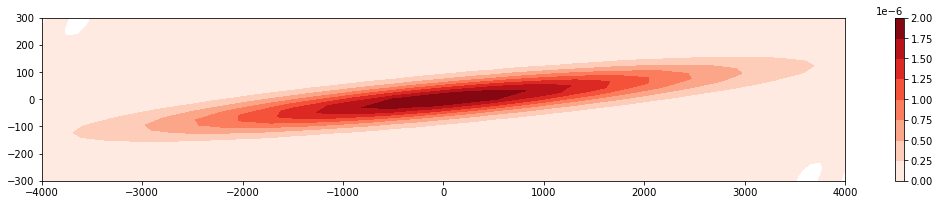

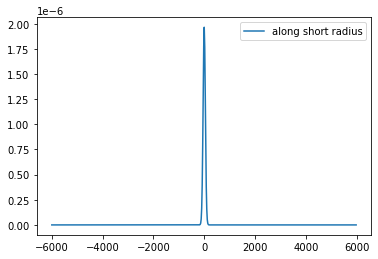

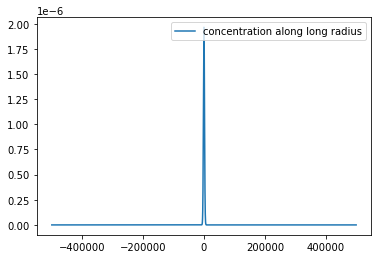

In [17]:
fig, ax = plt.subplots(1, figsize=(18,3))


plt.contourf(X1d, Y1d, C1d, cmap='Reds')
# plt.contourf(X1d, Y1d, C1d,  levs, locator=ticker.LogLocator(), cmap='Reds')
plt.colorbar()

# plt.ylim(Ymin, Ymax)
# plt.xlim(Xmin, Xmax)

plt.ylim(-3e2, 3e2)
plt.xlim(-4e3, 4e3)

plt.show()

leng = np.zeros(Nb)
for i in range(Nb):
    leng[i] = 0.5*LenB + LenB*i
    
plt.plot(leng-leng[Nb_mid], C1d[Na_mid,:], label='along short radius')
plt.legend()
plt.show()

leng2 = np.zeros(Na)
for i in range(Na):
    leng2[i] = 0.5*LenA + LenA*i
    
plt.plot(leng2-leng2[Na_mid], C1d[:,Nb_mid], label='concentration along long radius')
plt.legend(loc='upper right')
plt.show()


In [18]:
# Calculate the concentration given the La and Lb

# La, Lb = calc_LaLb(C1d, LenA, LenB)

La = Length
Lb = LenB

print(LenA, LenB)
print(La, Lb)


C_box = np.zeros(Nb)
for i in range(Nb):
    C_box[i] = sum(C1d[:,i]) *(LenA*LenB)/ (La*Lb)


200 20
7200 20


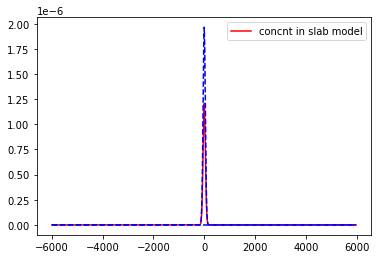

In [19]:
# for the 2nd phase: 1D model

leng = np.zeros(Nb)
for i in range(Nb):
    leng[i] = 0.5*LenB + LenB*i
    
plt.plot(leng-leng[Nb_mid], C_box, 'r', label='concnt in slab model')

plt.plot(leng-leng[Nb_mid], C1d[Na_mid,:], 'b--')
plt.plot(leng-leng[Nb_mid], C1d[Na_25,:], 'b--')

plt.legend()
plt.show()

In [20]:
# total mass check

total_mass = np.sum(Concnt, axis=(0,1))*Dx*Dy
Total_m1 = np.sum(C1d, axis=(0,1))*LenA*LenB
mass_1D = np.sum(C_box)*La*Lb

print(total_mass, Total_m1, mass_1D)
print((total_mass-mass_1D)/total_mass)

0.9999999999999998 0.9999988595356915 0.9999988595356918
1.140464307991529e-06


In [21]:
##################################################################
#
# run 1D
#
##################################################################

In [22]:
# diffusion process
def Difussion2(C, Diff_y, Dt, Dy, Ny):
    C_diff = C*0.0
    
    C_diff[1:Ny-1] = C[1:Ny-1] + Dt*Diff_y*(C[0:Ny-2]+C[2:Ny]-2*C[1:Ny-1])/(Dy*Dy)
    
    return C_diff

In [23]:
%%time

print('Theta origin:',Theta)


Nt = int(time2/Dt_1d)

Diff_v = Diff_y
Diff_h = Diff_x

for it in np.arange(1,Nt+1,1): 
    # shear effect:
    S = La*Lb
    Theta_old = Theta
    Theta = np.arctan( np.tan(Theta) + U_shear*Dt_1d )
    La = La * (np.tan(Theta)**2+1)**0.5 / (np.tan(Theta_old)**2+1)**0.5
#     La = La * (1 + U_shear**2 *Dt_1d**2 *np.cos(Theta)**2 + 2*U_shear*Dt_1d*np.sin(Theta)*np.cos(Theta) )**0.5
    Lb = S/La
    
    Theta1 = (Theta+Theta_old)/2
    Diff_b = Diff_v*np.sin(Theta1) # + Diff_h*np.cos(Theta1)
    Diff_a = Diff_v*np.cos(Theta1) + Diff_h*np.sin(Theta1)
    
    # Test confusion CFL condition
    if 2*Diff_b*Dt_1d/(Lb**2)>1:
        print('****************************************')
        print('WARNING: diff Y: CFL condition is not satisfied')
        print('Combing grid to incease Dy')
        print('****************************************')
        
        print('time for combing slab (hours):', it*Dt_1d/3600, 'hour', 'Lb:', Lb)
        
        Lb = 2*Lb
        C_new = C_box*0.0
        for i in range(Nb_50):
            C_box[i] = 0.5* ( C_box[2*i]+C_box[2*i+1] )
        C_new[Nb_25-1:Nb_75-1] = C_box[0:Nb_50]
        C_box = C_new    
        
    
    # diffusion effect in short radius
    C_box = Difussion2(C_box, Diff_b, Dt_1d, Lb, Nb)
        
    # diffusion effect in long radius:
#     La_old = La
#     La = np.sqrt(La_old**2+2.0*Diff_a*Dt_1d)
#     C_box = C_box *La_old /La

    if it*Dt_1d%600==0:
        df = pd.DataFrame(C_box)
        df.to_csv('Concnt_1d_'+str(int(it*Dt_1d/600))+'_10min.txt', index = False)
        
        df1 = pd.DataFrame([Lb,La])
        df1.to_csv('Lb_'+str(int(it*Dt_1d/600))+'_10min.txt', index = False)       
    
    
    # divide plume cross-section into 5 segments once the cross-section is highly distorted
#    Judge_L = 2*110*1000 # [m]
#    if La>Judge_L:
print('Theta finish:',Theta)

Theta origin: 1.531927024616975
Theta finish: 1.5681031969562862
CPU times: user 24.3 s, sys: 519 ms, total: 24.9 s
Wall time: 38.3 s


In [24]:
print(La,Lb)
print(La/Na)

103889.84803550987 1.3860834597696199
20.777969607101973


In [25]:
Na, Nb

(5000, 600)

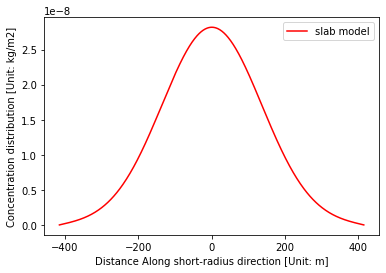

Original:  1.0
mass in 2D:  0.9999999999999998
mass in 1D:  0.9953640432605908


In [26]:
# plot

leng = np.zeros(Nb)
for i in range(Nb):
    leng[i] = 0.5*Lb + Lb*i

plt.plot(leng-Lb*Nb_50, C_box,'r',label='slab model')

#plt.ylim(0, 14)

plt.xlabel('Distance Along short-radius direction [Unit: m]')
plt.ylabel('Concentration distribution [Unit: kg/m2]')
plt.legend()
plt.show()


print('Original: ', Original)
print('mass in 2D: ', np.sum(Concnt, axis=(0,1))*Dx*Dy)
print('mass in 1D: ', np.sum(C_box)*La*Lb)

In [27]:
###############################################################################################################
#
# run 2-D for comparison
#
###############################################################################################################

In [28]:
# Test confusion CFL condition

if 2*Diff_y*Dt_2d/(Dy**2)>1:
    print('****************************************')
    print('WARNING: diff Y: CFL condition is not satisfied')
    print('Try to increase Dy or decrease Dt_2d')
    print('****************************************')
    
if 2*Diff_x*Dt_2d/(Dx**2)>1:
    print('****************************************')
    print('WARNING: diff X: CFL condition is not satisfied')
    print('Try to increase Dx or decrease Dt_2d')
    print('****************************************')
    
# Test advective CFL condition
if np.max(U)*Dt_2d/Dx>1:
    print('****************************************')
    print('WARNING: adv X: CFL condition is not satisfied')
    print('Try to increase Dx or decrease Dt_2d')
    print('****************************************')

    contours = plt.contourf(X,Y,Concnt)
#    plt.clabel(contours, inline=True, fontsize=8)
    plt.show()

In [29]:
%%time

# for validation: Gaussian analytical results Vs. 1D slab model.

print('time1=', time1/3600, '(h); time2', time2/3600, 'h')
t_total = time1+time2

Concnt2 = Concnt

# time run
Nt           = int(time2/Dt_2d)

print(Diff_x, Diff_y, Dt_2d, Dx, Dy, Nx, Ny)

for t in tqdm(np.arange(1,Nt+1,1)):
    Concnt2 = Adv_Diff2(Concnt2, U, Diff_x, Diff_y, Dt_2d, Dx, Dy, Nx, Ny)
    
#     if t*Dt_2d%600==0:
#         df = pd.DataFrame(Concnt2)
#         df.to_csv('Concnt_2d_'+str(int(t*Dt_2d/600))+'_10min.txt', index = False)
        
        
#         file1d = open('Concnt_2d_'+str(int(t*Dt_2d/3600))+'.txt',"w")
#         for i in range(Nx):
#             file1d.write(str(Concnt2[:,i])+ '\n')
#         file1d.close()
    

time1= 5.461111111111111 (h); time2 48.0 h
10.0 0.15 10 200 20 5000 300
CPU times: user 16min 36s, sys: 7min 11s, total: 23min 47s
Wall time: 23min 47s


[[-200    0  200]
 [-200    0  200]
 [-200    0  200]] [[-20 -20 -20]
 [  0   0   0]
 [ 20  20  20]] [[2.45245682e-08 2.44986800e-08 2.44714404e-08]
 [2.48414257e-08 2.48421256e-08 2.48414257e-08]
 [2.44714404e-08 2.44986800e-08 2.45245682e-08]]
0 0 2.484212557268919e-08


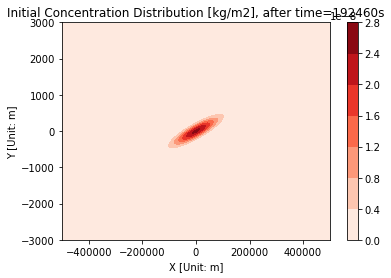

In [43]:

contours = plt.contourf(X, Y, Concnt2, cmap='Reds')
# contours = plt.contourf(X, Y, Concnt2, levs, locator=ticker.LogLocator(), cmap='Reds')

plt.ylim(Ymin, Ymax)
plt.xlim(Xmin, Xmax)

plt.colorbar()
plt.xlabel('X [Unit: m]')
plt.ylabel('Y [Unit: m]')
plt.title( 'Initial Concentration Distribution [kg/m2], after time='+str(t_total)+'s' )
print(X[j_init-1:j_init+2,i_init-1:i_init+2],Y[j_init-1:j_init+2,i_init-1:i_init+2], \
      Concnt2[j_init-1:j_init+2,i_init-1:i_init+2])
print(X[j_init,i_init],Y[j_init,i_init], Concnt2[j_init,i_init])
plt.show()



In [31]:
# calculate ScaleX and ScaleY containing 99%  of total mass

Xscale2, Yscale2 = Get_XYscale(Concnt2, Dx, Dy, Nx, Ny, frac)

Height2 = Lb*Nb # Yscale2 # refernce of the plume cross-section vertical scale for 1D initial
Length2 = Xscale2

Theta2 = math.atan(Xscale2/Yscale2)
print(Height2, Length2, Theta2)
print('Theta & Theta2', Theta, Theta2)
math.degrees(math.atan(Xscale2/Yscale2))

831.6500758617719 209400 1.566402849810579
Theta & Theta2 1.5681031969562862 1.566402849810579


89.74827231141074

LenB, LenA:  1.3860834597696199 200
Nb, Na:  600 5000
Y1d.shape:  (5000, 600)


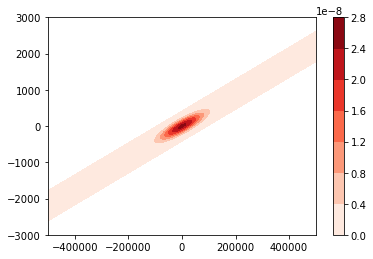

leng2.shape: (600,)
C1d2.shape: (5000, 600)


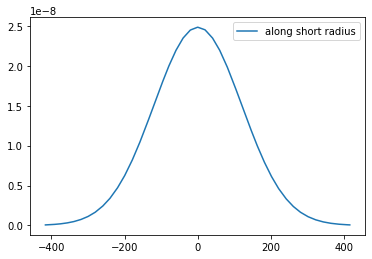

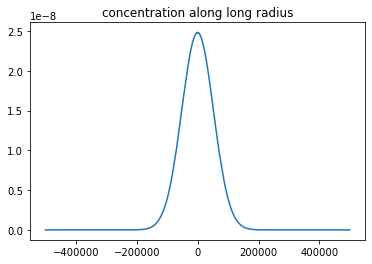

CPU times: user 5min 18s, sys: 1.07 s, total: 5min 19s
Wall time: 5min 19s


In [32]:
%%time

# 1D grid length

# LenB doesn't have big influence on final results
LenB2 = Lb # Dy # number is a arbitraty number
LenA2 = Dx # Dx*1.5 # Dx
print('LenB, LenA: ', LenB2, LenA2)

Nb2 = int(Height2/LenB2) # short radius
Nb2 = math.ceil(Nb2/4)*4

Na2 = Nx # int(Length2/Dx) # Nx # long radius
Na2 = math.ceil(Na2/4)*4
print('Nb, Na: ', Nb2, Na2)

Nb2_25  = int(Nb2/4)
Nb2_mid = Nb2_50 = int(Nb2/4*2)
Nb2_75  = int(Nb2/4*3)

Na2_25  = int(Na2/4)
Na2_mid = Na2_50 = int(Na2/4*2)
Na2_75  = int(Na2/4*3)


C1d2, X1d2, Y1d2 = tilt_C2d(Concnt2, x, y, Dx, Dy, Nx, Ny, Theta2, Na2, Nb2, LenA2, LenB2)

plt.contourf(X1d2, Y1d2, C1d2, cmap='Reds')

plt.colorbar()

plt.ylim(Ymin, Ymax)
plt.xlim(Xmin, Xmax)
plt.show()





leng2 = np.zeros(Nb2)
for i in range(Nb2):
    leng2[i] = 0.5*LenB2 + LenB2*i
print('leng2.shape:', leng2.shape)
print('C1d2.shape:', C1d2.shape)   

plt.plot(leng2-leng2[Nb2_mid], C1d2[Na2_mid,:], label='along short radius')
plt.legend()
plt.show()




leng2 = np.zeros(Na2)
for i in range(Na2):
    leng2[i] = 0.5*LenA2 + LenA2*i
    
plt.plot(leng2-leng2[Na2_mid], C1d2[:,Nb2_mid])
plt.title('concentration along long radius')
plt.show()


In [33]:
# Calculate the concentration given the La and Lb

#La2, Lb2 = calc_LaLb(C1d2, LenA2, LenB2)

La2 = La # Length2
Lb2 = Lb

#La2 = La # #######################################  important  #####

print(LenA2, LenB2)
print(La2, Lb2)

C_box2 = np.zeros(Nb2)
C_box2_Asum = np.zeros(Nb2)

for i in range(Nb2):
    C_box2[i] = sum(C1d2[:,i]) *(LenA2*LenB2)/ (La2*Lb2)
    C_box2_Asum[i] = sum(C1d2[:,i]) *(LenA2*LenB2)
    

200 1.3860834597696199
103889.84803550987 1.3860834597696199


In [34]:
print('Original: ', Original)
print('mass in 2D: ', np.sum(Concnt, axis=(0,1))*Dx*Dy)
print('mass in 1D: ', np.sum(C_box)*La*Lb)
print('mass in 2D again: ', np.sum(Concnt2, axis=(0,1))*Dx*Dy)
print('mass in 2D_to_1D for comparison:', np.sum(C_box2)*La2*Lb2)
print('mass in tilting 2D:', np.sum(C1d2, axis=(0,1))*LenA2*LenB2)
Lb2, LenB2, La2, LenA2

Original:  1.0
mass in 2D:  0.9999999999999998
mass in 1D:  0.9953640432605908
mass in 2D again:  0.9999999999999992
mass in 2D_to_1D for comparison: 0.9991886848365052
mass in tilting 2D: 0.9991886848365071


(1.3860834597696199, 1.3860834597696199, 103889.84803550987, 200)

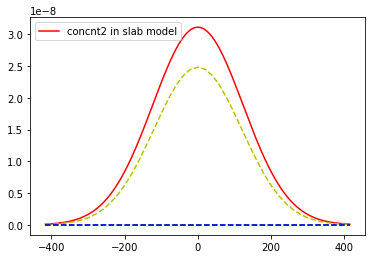

In [35]:
# for the 2nd phase: 1D model


leng2 = np.zeros(Nb2)
for i in range(Nb2):
    leng2[i] = 0.5*LenB2 + LenB2*i
    
plt.plot(leng2-leng2[Nb2_mid], C_box2, 'r', label='concnt2 in slab model')

plt.plot(leng2-leng2[Nb2_mid], C1d2[Na2_mid,:], 'y--')
plt.plot(leng2-leng2[Nb2_mid], C1d2[Na2_75,:], 'g--')
plt.plot(leng2-leng2[Nb2_mid], C1d2[Na2_25,:], 'b--')

plt.legend()
plt.show()

# ??? red line ???

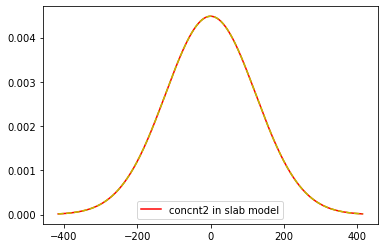

In [36]:
# for the 2nd phase: 1D model


leng2 = np.zeros(Nb2)
for i in range(Nb2):
    leng2[i] = 0.5*LenB2 + LenB2*i
    
plt.plot(leng2-leng2[Nb2_mid], C_box2_Asum, 'r', label='concnt2 in slab model')

plt.plot(leng2-leng2[Nb2_mid], (LenA2*LenB2)*np.sum(C1d2[:,:], axis=0), 'y--')
# plt.plot(leng2-leng2[Nb2_mid], C1d2[Na2_75,:], 'g--')
# plt.plot(leng2-leng2[Nb2_mid], C1d2[Na2_25,:], 'b--')

plt.legend()
plt.show()


-0.09442667961671425
2.8179628476257925e-08 3.111799767282327e-08
280 7200
831.6500758617719 209400


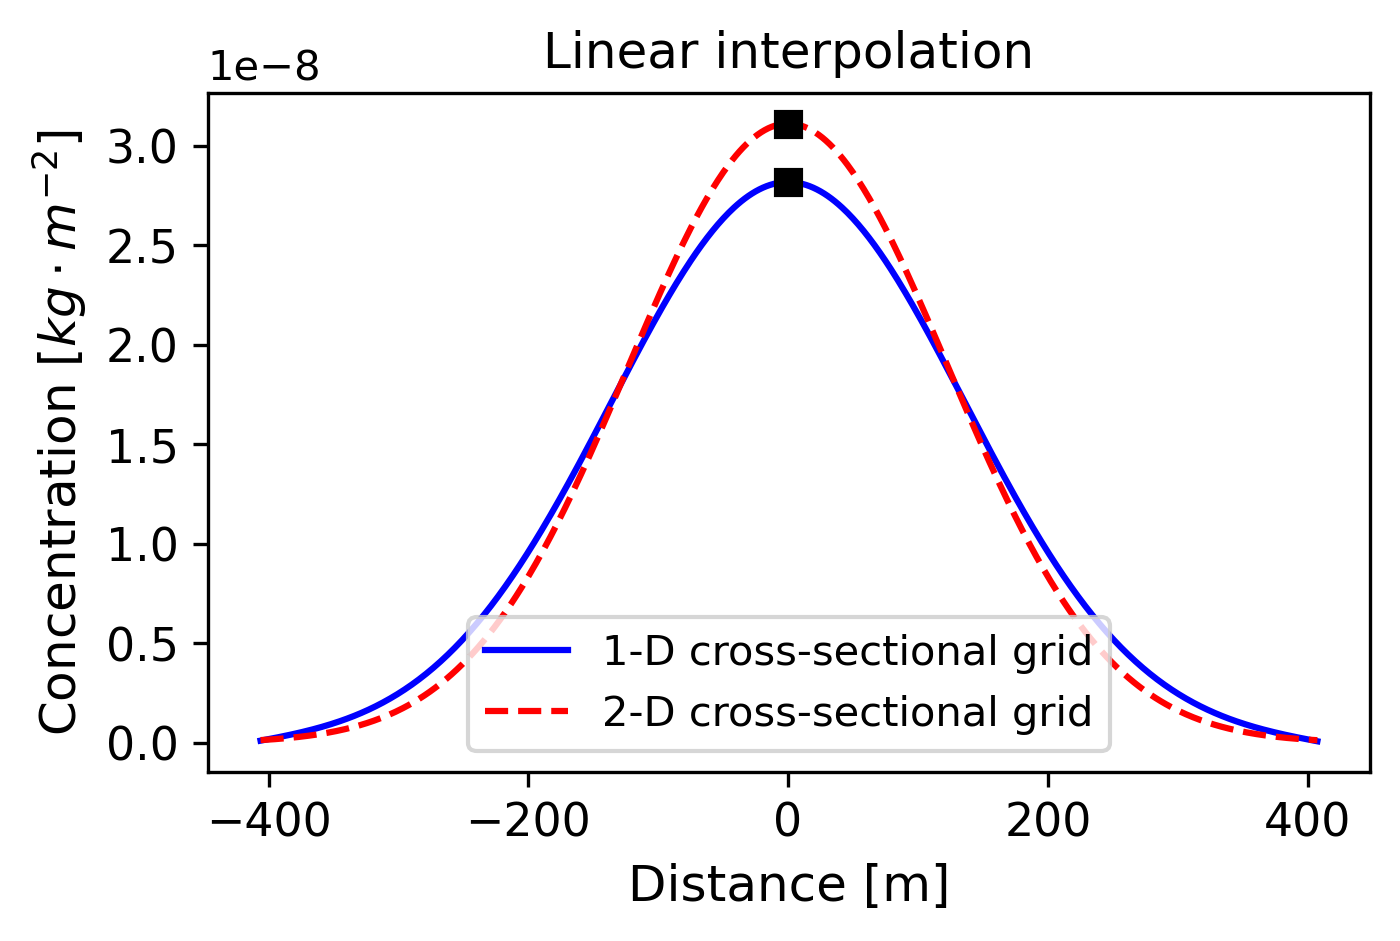

In [44]:
# plot

leng = np.zeros(Nb)
for i in range(Nb):
    leng[i] = 0.5*Lb + Lb*i
    

# plot
fig = plt.figure(figsize=(5,3), dpi=300)
ax = fig.add_subplot()

Num = 5

ax.plot(leng[2+Num:Nb-Num]-leng[Nb_mid], C_box[2+Num:Nb-Num],'b',label='1-D cross-sectional grid')
ax.plot(leng[2+Num:Nb-Num]-leng[Nb_mid], C_box2[2+Num:Nb-Num], 'r--', label='2-D cross-sectional grid') # ???
# ax[0].plot(0*leng2,C_box2, 'k--')

ax.plot(0, max(C_box), 'ks')
ax.plot(0, max(C_box2), 'ks')


# ax.set_title(f'(a)', loc='left')
ax.set_ylabel('Concentration [$kg \cdot m^{-2}$]', fontsize=12)
ax.set_xlabel('Distance [m]', fontsize=12)

# tick_locs = [0, 1e5,2e5, 3e5, 4e5, 5e5]
# tick_lbls = ['0', '1e5', '2e5', '3e5', '4e5', '5e5']
# ax.set_yticks(np.array(tick_locs))
# ax.set_yticklabels(tick_lbls,fontsize=11)

ax.tick_params(axis='x', labelsize=11)  # to Set Matplotlib Tick Labels Font Size
ax.tick_params(axis='y', labelsize=11)

ax.set_title('Linear interpolation')

# ax[0].set_xlim(-1000,1000)
ax.legend()

print( (max(C_box) - max(C_box2))/ max(C_box2) )
print(max(C_box) , max(C_box2))
print(Height, Length)
print(Height2, Length2)

In [38]:
C_box_Asum = C_box*La*Lb

No handles with labels found to put in legend.


-0.094426679616714
0.00405786650058113 0.004480991664886537
280 7200
831.6500758617719 209400
Na, Nb: 5000, 600
La, Lb=103889.8, 1.4 & La2, lb2=103889.8, 1.4


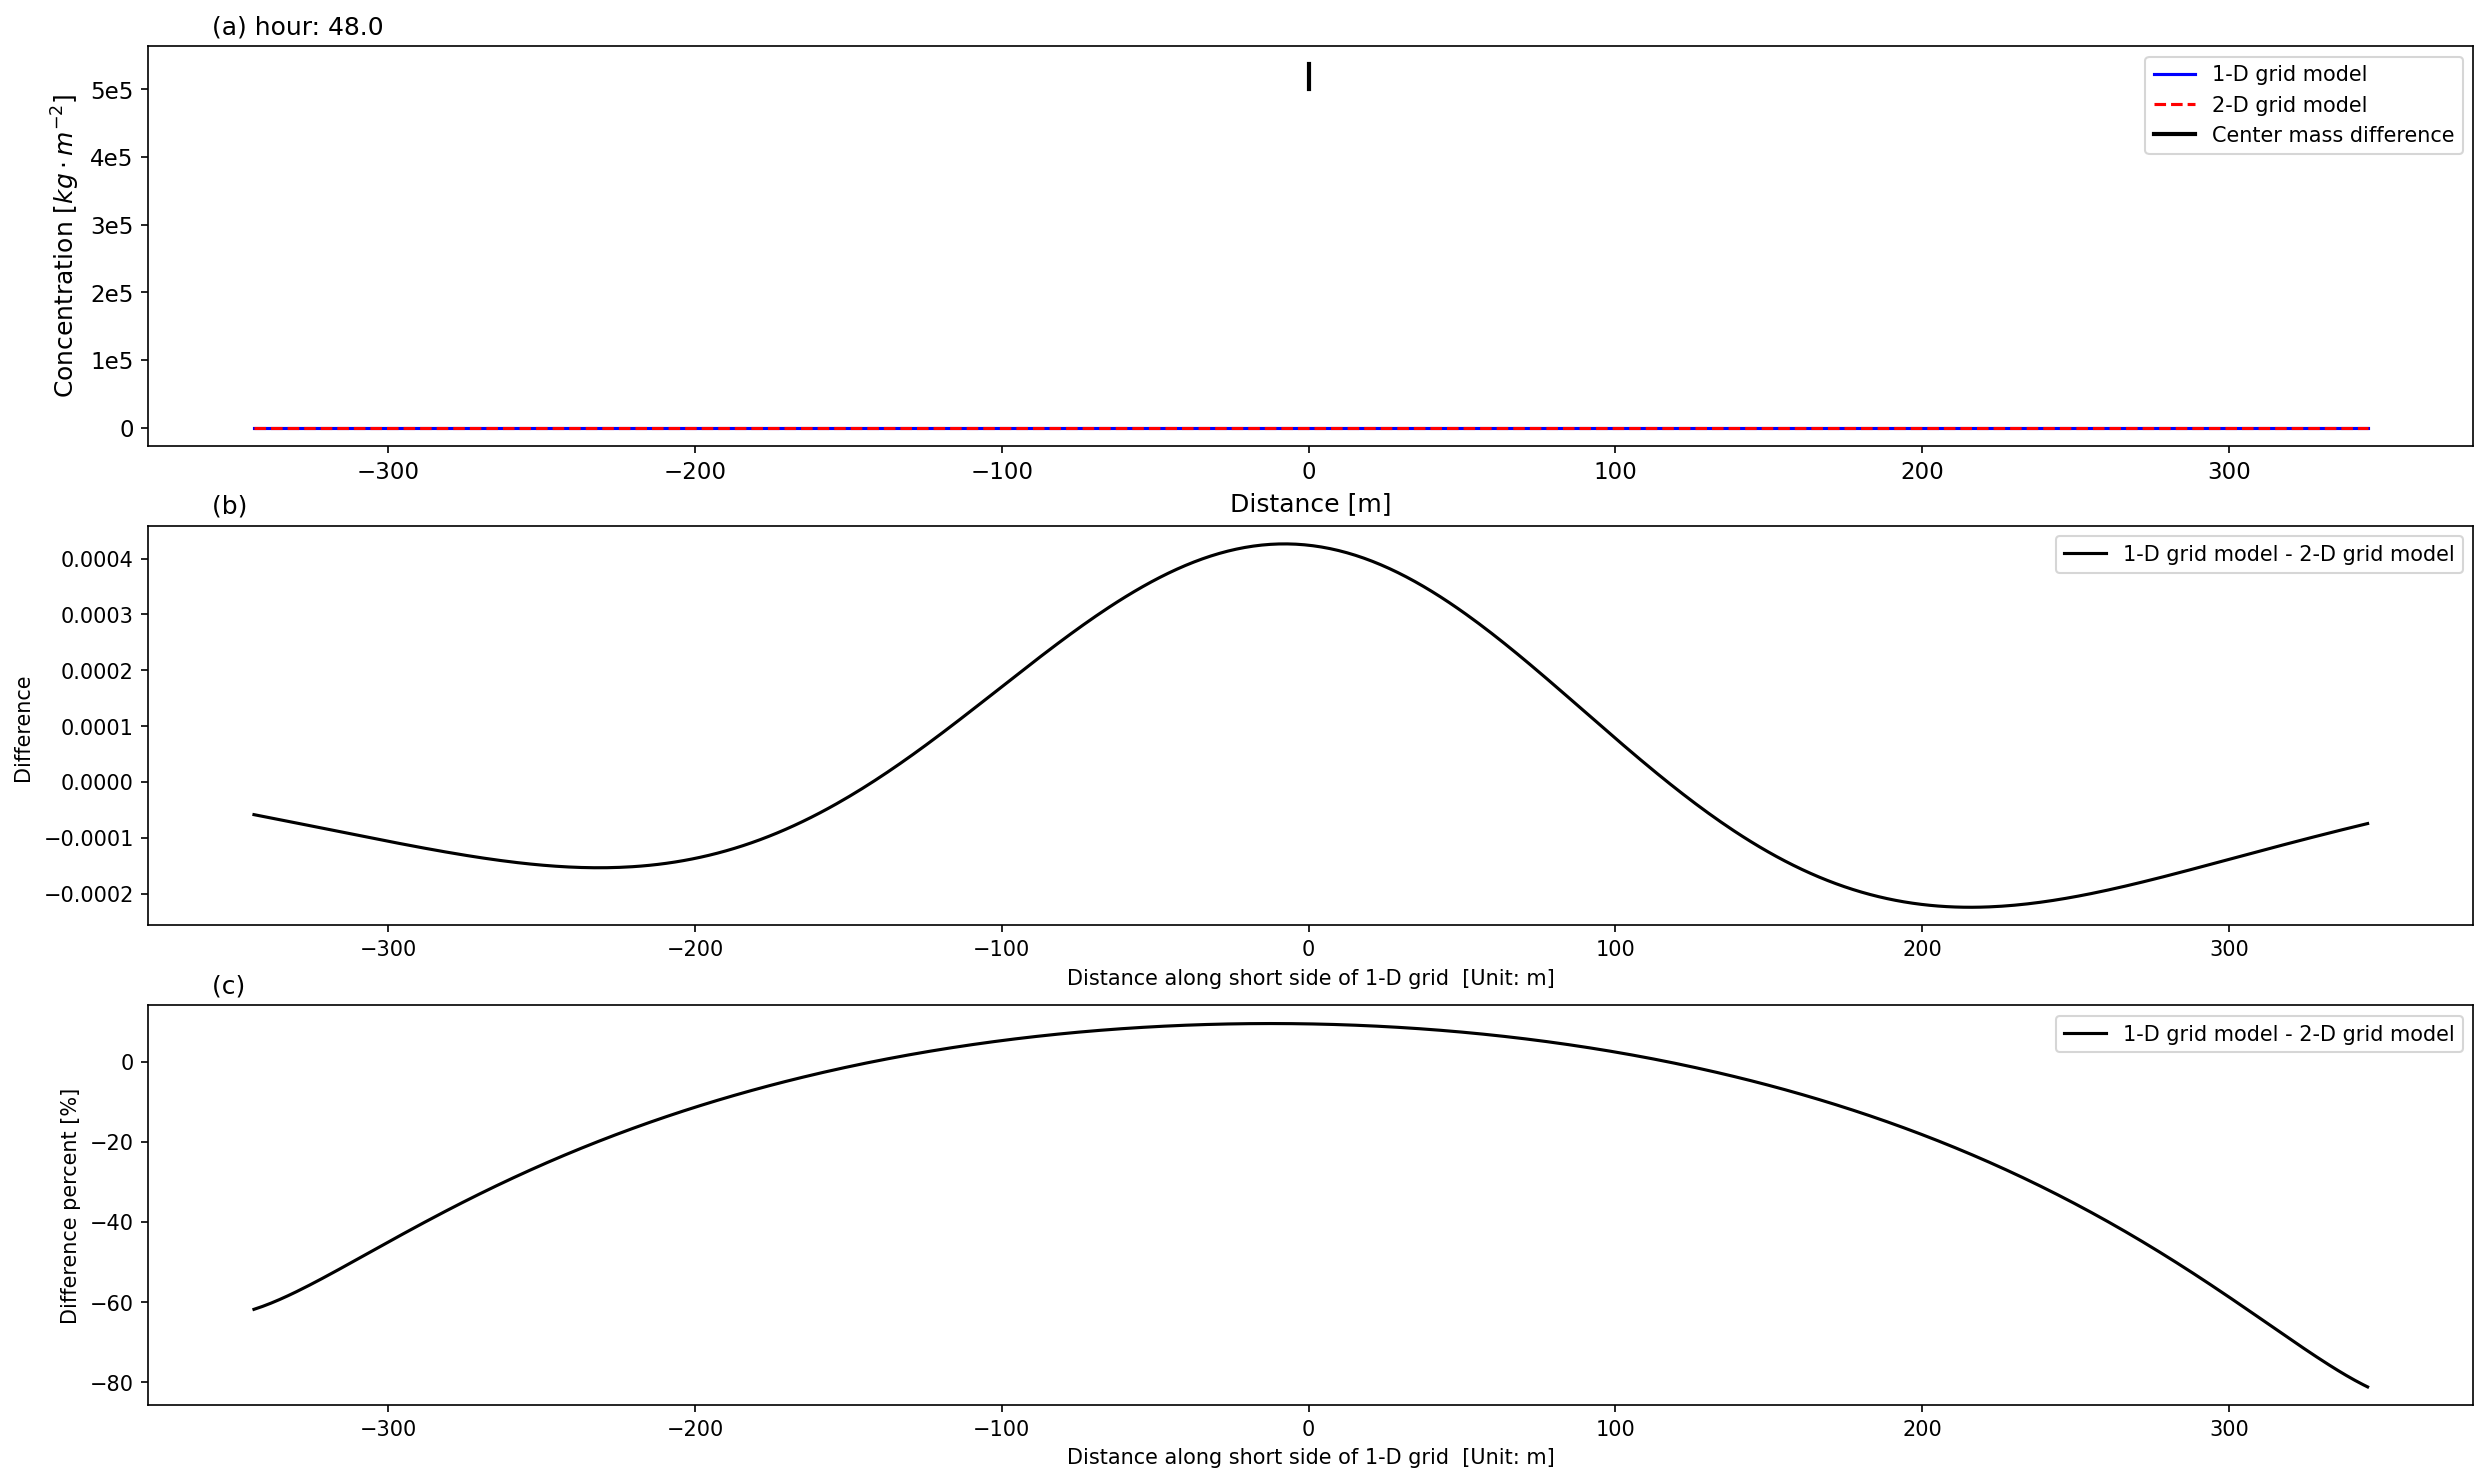

In [39]:
# plot

leng = np.zeros(Nb)
for i in range(Nb):
    leng[i] = 0.5*Lb + Lb*i
    

# plot
fig, ax = plt.subplots(3,figsize=(20,12),dpi=150)

ax[0].plot(leng[2+50:Nb-50]-leng[Nb_mid], C_box_Asum[0+50:Nb-2-50],'b',label='1-D grid model')
ax[0].plot(leng[2+50:Nb-50]-leng[Nb_mid], C_box2_Asum[2+50:Nb-50], 'r--', label='2-D grid model') # ???
# ax[0].plot(0*leng2,C_box2, 'k--')

ax[0].plot([0, 0], [500000, 537000], color='k', linestyle='-', linewidth=2, label='Center mass difference')


ax[0].set_title(f'        (a) hour: {time2/3600}', loc='left')
ax[0].set_ylabel('Concentration [$kg \cdot m^{-2}$]', fontsize=12)
ax[0].set_xlabel('Distance [m]', fontsize=12)

tick_locs = [0, 1e5,2e5, 3e5, 4e5, 5e5]
tick_lbls = ['0', '1e5', '2e5', '3e5', '4e5', '5e5']
ax[0].set_yticks(np.array(tick_locs))
ax[0].set_yticklabels(tick_lbls,fontsize=11)

ax[0].tick_params(axis='x', labelsize=11)  # to Set Matplotlib Tick Labels Font Size
ax[0].tick_params(axis='y', labelsize=11)

# ax[0].set_xlim(-1000,1000)
ax[0].legend()

print( (max(C_box_Asum) - max(C_box2_Asum))/ max(C_box2_Asum) )
print(max(C_box_Asum) , max(C_box2_Asum))
print(Height, Length)
print(Height2, Length2)

# plot concentratin difference
ax[1].plot(leng[2+50:Nb-50]-leng[Nb_mid], (C_box2_Asum[2+50:Nb-50]-C_box_Asum[0+50:Nb-2-50]),'k',\
           label='1-D grid model - 2-D grid model')
# ax[1].plot(0*leng2,C_box2, 'k--')


ax[1].set_title('        (b)', loc='left')
ax[1].set_xlabel('Distance along short side of 1-D grid  [Unit: m]')
ax[1].set_ylabel('Difference ')
# ax[1].set_xlim(-1000,1000)
ax[1].legend()

#plt.ylim(0, 14)
# print('La, Lb={:.1f}, {:.1f} & La2, lb2={:.1f}, {:.1f}'.format(La,Lb, La2, Lb2))
plt.legend()


# (c)
# plot concentratin difference
ax[2].plot(leng[2+50:Nb-50]-leng[Nb_mid], 100*(C_box2_Asum[2+50:Nb-50]-C_box_Asum[0+50:Nb-2-50]) \
           /C_box2_Asum[2+50:Nb-50],\
           'k', label='1-D grid model - 2-D grid model')
# ax[1].plot(0*leng2,C_box2, 'k--')

ax[2].set_title('        (c)', loc='left')
ax[2].set_xlabel('Distance along short side of 1-D grid  [Unit: m]')
ax[2].set_ylabel('Difference percent [%]')
# ax[2].set_xlim(-1000,1000)
ax[2].legend()

#plt.ylim(0, 14)
print(f'Na, Nb: {Na}, {Nb}')
print('La, Lb={:.1f}, {:.1f} & La2, lb2={:.1f}, {:.1f}'.format(La,Lb, La2, Lb2))
plt.show()


In [40]:
print('1D model hours:', time2/3600)

print('Original: ', Original)
print('mass in 2D: ', np.sum(Concnt2, axis=(0,1))*Dx*Dy)
print('mass in 1D: ', np.sum(C_box)*La*Lb)
print('La1D, Lb1D: ', La, Lb)
print('La2D, Lb2D: ', La2, Lb2)
print(f'time1={time1:0.4f}, time2={time2:0.4f}')

1D model hours: 48.0
Original:  1.0
mass in 2D:  0.9999999999999992
mass in 1D:  0.9953640432605908
La1D, Lb1D:  103889.84803550987 1.3860834597696199
La2D, Lb2D:  103889.84803550987 1.3860834597696199
time1=19660.0000, time2=172800.0000


In [41]:
a = (C_box2[2+180:Nb-180]-C_box[0+180:Nb-2-180])/C_box2[2+180:Nb-180]

In [42]:
a.max()

0.09545188257725859